In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.UNET import UNet2D

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [3]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 10
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
alphas_bar_sqrt[-1] = 0
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
one_minus_alphas_bar_sqrt[-1] = 1


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [4]:
BATCH_SIZE = 1024


class QX:
    def __init__(self, time_step=None):
        self.ts = time_step

    def __call__(self, sample):
        return q_x(sample, torch.tensor(self.ts))


transform = transforms.Compose([
    transforms.ToTensor(),
    QX(list(range(10)))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

(array([22.16124199,  0.09430317,  0.15717191,  0.03143439,  0.06286875,
         0.12573755,  0.0943032 ,  0.06286873,  0.        ,  0.06286878,
         0.09430317,  0.06286878,  0.        ,  0.        ,  0.        ,
         0.03143441,  0.18860619,  0.22004088,  0.        ,  0.03143441,
         0.03143437,  0.09430324,  0.12573746,  0.09430324,  0.81729351]),
 array([-0.01215223,  0.02842468,  0.06900159,  0.1095785 ,  0.1501554 ,
         0.19073232,  0.23130922,  0.27188611,  0.31246305,  0.35303995,
         0.39361686,  0.43419376,  0.47477067,  0.51534754,  0.55592448,
         0.59650141,  0.63707829,  0.67765522,  0.7182321 ,  0.75880903,
         0.79938591,  0.83996284,  0.88053972,  0.92111665,  0.96169353,
         1.00227046]),
 <BarContainer object of 25 artists>)

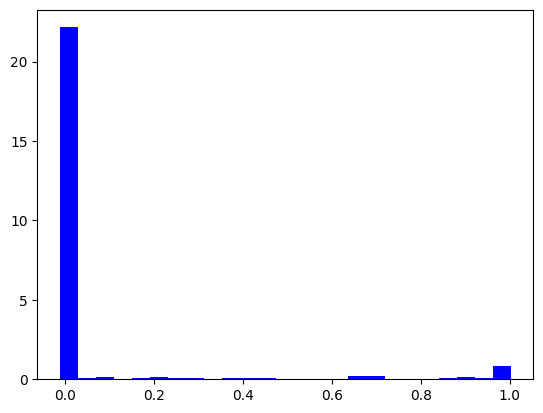

In [5]:
img0 = next(iter(train_loader))[0][0]
plt.hist(img0[0].flatten(), bins=25, density=True, color='b')

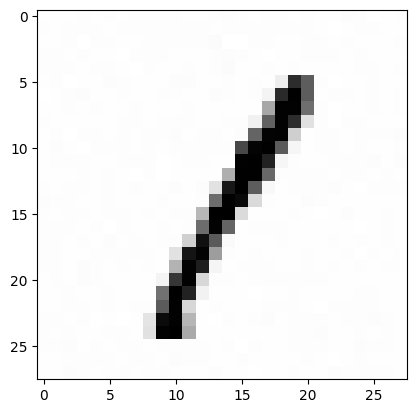

In [6]:
plt.imshow(img0[0], cmap='Greys')

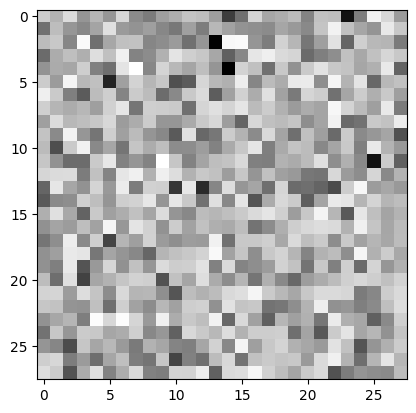

In [7]:
plt.imshow(img0[-1], cmap='Greys')

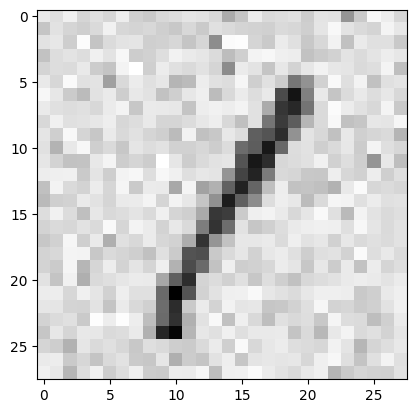

In [8]:
plt.imshow(img0[-2], cmap='Greys')

In [9]:
class TimestepLike(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size * 2)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hiddenSize = hidden_size

    def forward(self, X):
        h0 = self.encoder(X)
        h1, h2 = torch.chunk(h0, 2, dim=-1)
        h = torch.mul(h1, torch.softmax(h2, dim=-1))
        return self.decoder(nn.functional.leaky_relu(h))


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = TimestepLike(28 * 28, 256)
        self.mu = TimestepLike(256, 28 * 28)
        self.var = TimestepLike(256, 28 * 28)
        self.decoder = nn.Sequential(nn.Linear(28 * 28, 256),
                                     nn.LeakyReLU(),
                                     nn.Linear(256, 28 * 28))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, X):
        h = self.h(X)
        mu = self.mu(h)
        var = self.var(h)
        return self.decoder(self.reparameterize(mu, var))

In [49]:
# model = nn.Sequential(nn.Linear(28 * 28, 8 * 28),
#                       nn.ReLU(),
#                       # nn.Linear(256, 128),
#                       # nn.ReLU(),
#                       # nn.Linear(128, 256),
#                       # nn.ReLU(),
#                       nn.Linear(8 * 28, 28 * 28)).to('cuda')
# model = nn.Linear(28 * 28, 28 * 28).to('cuda')
model = UNet2D(1, 1).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=False, threshold=1e-3)

In [50]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            X = data[:, -1].to('cuda').view(-1, 1, 28, 28)
            Y = data[:, -2].to('cuda').view(-1, 1, 28, 28)
            optimizer.zero_grad()
            output = model(X)
            loss = L2Loss(output, Y)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.8f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss

In [67]:
for epoch in range(1, 1001):
    loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 27%|██▋       | 16/59 [00:04<00:13,  3.24batch/s,  Epoch: 25 	Loss: 0.06567995	 lr: 0.00010000]


KeyboardInterrupt: 

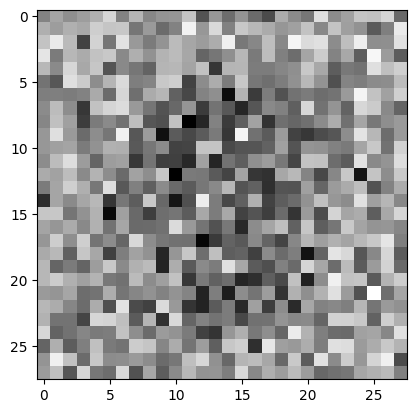

In [68]:
img0 = next(iter(train_loader))[0][0]
y = model(img0.to('cuda').view(-1, 1, 28, 28))
plt.imshow(y[-1].cpu().detach().view(28, 28), cmap='Greys')

(array([0.03216047, 0.08040117, 0.08040117, 0.08040117, 0.12864187,
        0.2412035 , 0.16080233, 0.16080233, 0.22512327, 0.30552443,
        0.2894442 , 0.32160467, 0.59496863, 0.83617213, 1.18993727,
        1.3507396 , 1.55978263, 1.447221  , 1.27033843, 0.93265353,
        0.5306477 , 0.3859256 , 0.22512327, 0.12864187, 0.0482407 ]),
 array([-1.2890209 , -1.20969927, -1.13037765, -1.05105603, -0.9717344 ,
        -0.89241278, -0.81309116, -0.73376954, -0.65444791, -0.57512629,
        -0.49580467, -0.41648304, -0.33716142, -0.2578398 , -0.17851818,
        -0.09919655, -0.01987493,  0.05944669,  0.13876832,  0.21808994,
         0.29741156,  0.37673318,  0.45605481,  0.53537643,  0.61469805,
         0.69401968]),
 <BarContainer object of 25 artists>)

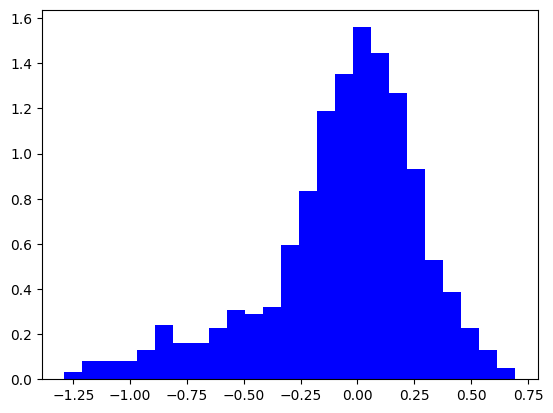

In [69]:
plt.hist((y[-1].cpu().detach().view(28, 28) - img0[-2]).flatten(), bins=25, density=True, color='b')

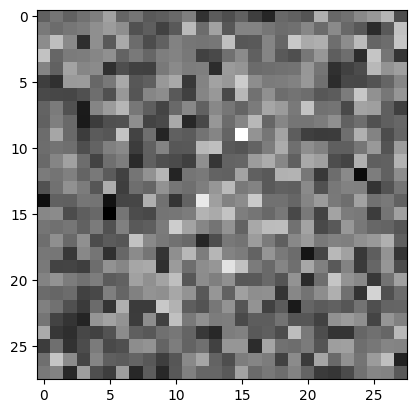

In [70]:
plt.imshow((y[-1].cpu().detach().view(28, 28) - img0[-1]).view(28, 28), cmap='gray')

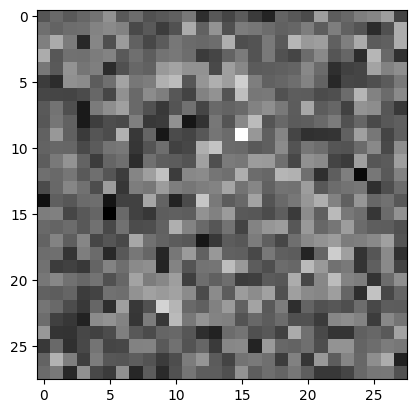

In [71]:
plt.imshow((img0[-2] - img0[-1]).view(28, 28), cmap='gray')

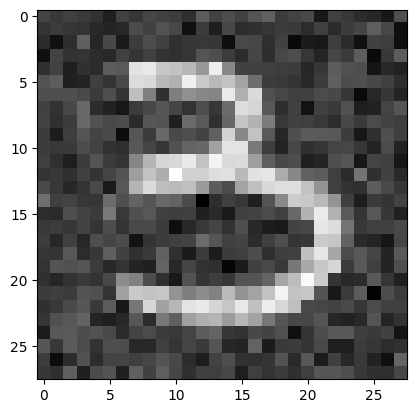

In [72]:
plt.imshow((img0[-2]).view(28, 28), cmap='gray')

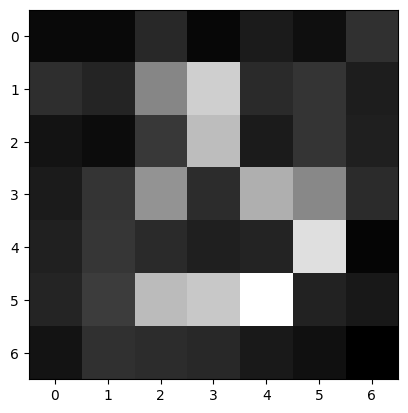

In [73]:
plt.imshow((transforms.Resize(size=(7,7))(img0[-2][None,None,:,:])[0,0]), cmap='gray')

In [59]:
img0[-2].shape

torch.Size([28, 28])